In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import keras.backend as K

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output


In [2]:
PATH = "data"
PREDICTION_SAVE_PATH = "predictions"
AUTOTUNE = tf.data.experimental.AUTOTUNE
WIDTH, HEIGHT = 512, 512
BATCH_SIZE = 4

In [3]:
def load_data(path):
    images = sorted(glob(f"{path}/images/*.png"))
    masks = sorted(glob(f"{path}/masks/*.png"))
    return images, masks

image_files, mask_files = load_data(PATH)

In [4]:
print(len(image_files), len(mask_files))
DATASET_SIZE = len(image_files)

2667 2667


In [5]:
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/ 255.0
    #input_mask = tf.cast(input_mask, tf.uint8)
    input_mask = tf.cast(input_mask, tf.float32)/ 255.0
    #input_image = input_image/255.0
    #input_mask -= 1
    
    return input_image, input_mask


def parse_image(image_file, mask_file):
    #print(image_file, mask_file)
    img = tf.io.read_file(image_file)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, size=(WIDTH, HEIGHT))
    msk = tf.io.read_file(mask_file)
    msk = tf.image.decode_png(msk, channels=3)
    msk = tf.image.resize(msk, size=(WIDTH, HEIGHT))
    
    img, msk = normalize(img, msk)
    
    return img, msk

In [7]:
dataset = dataset.map(parse_image).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
def display(display_list):
    plt.figure(figsize=(WIDTH, HEIGHT))
    print(display_list)
    title = ['input image', 'true mask', 'predicted mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
for image, mask in dataset.take(2):
    sample_image, sample_mask = image, mask
    
display([sample_image[1], sample_mask[1]])

[<tf.Tensor: shape=(512, 512, 3), dtype=float32, numpy=
array([[[0.7882353 , 0.78431374, 0.7764706 ],
        [0.7882353 , 0.78431374, 0.7764706 ],
        [0.7873517 , 0.78343016, 0.775587  ],
        ...,
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883]],

       [[0.79154414, 0.7876226 , 0.77977943],
        [0.79154414, 0.7876226 , 0.77977943],
        [0.79154414, 0.7876226 , 0.77977943],
        ...,
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883]],

       [[0.8       , 0.79607844, 0.7882353 ],
        [0.8       , 0.79607844, 0.7882353 ],
        [0.80036384, 0.7964423 , 0.78859913],
        ...,
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883],
        [0.8509804 , 0.84313726, 0.84705883]],

       ...,

       [[0.11103863, 0.10711706, 0.09927392],
        [0.1

In [9]:
print(dataset)

<PrefetchDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[WIDTH, HEIGHT, 3], include_top=False)

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [12]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project'    
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [13]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [14]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  

    x = last(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer='adam',loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

    return model

model = unet_model(1)

In [16]:
def save_prediction(predicted, epoch):
    pred_img = tf.keras.preprocessing.image.array_to_img(predicted)
    pred_img.save(f"{PREDICTION_SAVE_PATH}/epoch-{epoch}.png")

#def create_mask(pred_mask):
#  pred_mask = tf.argmax(pred_mask, axis=-1)
#  pred_mask = pred_mask[..., tf.newaxis]
#  return pred_mask[0]

def create_mask(pred_mask):
    #preds=model.predict(image)  
    threshold = 0.5
    pred_mask[pred_mask > threshold] = 1.0
    pred_mask[pred_mask <= threshold] = 0.0 
    return pred_mask

def show_predictions(dataset=None, num=2, is_save=False, epoch=0):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      created_mask = create_mask(pred_mask)
      display([image[0], mask[0], created_mask])
      if is_save:
        save_prediction(created_mask, epoch)
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
#show_predictions(dataset, 2, True) 

In [17]:
train_size = int(0.9 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

print(train_size, val_size, test_size)

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size)
#validation_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

#print(train_ds, test_ds, validation_ds)
print(train_ds, test_ds)


2400 266 266
<TakeDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)> <TakeDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>


In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    epoch_num = epoch+1
    show_predictions(dataset, 2, True, epoch_num)
    print ('\nSample Prediction after epoch {}\n'.format(epoch_num))

In [19]:
print(train_ds)
print(test_ds)

<TakeDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>
<TakeDataset shapes: ((None, 512, 512, 3), (None, 512, 512, 3)), types: (tf.float32, tf.float32)>


In [20]:
steps_per_epoch = train_size//BATCH_SIZE


#history = model.fit(train_ds,
#                          steps_per_epoch=steps_per_epoch, validation_data=test_ds, epochs=3)

history = model.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
667/667 [==============================] - 366s 547ms/step - loss: -0.2703 - dice_coef: 1.2703 - binary_accuracy: 0.8679
Epoch 2/20
667/667 [==============================] - 363s 544ms/step - loss: -0.3336 - dice_coef: 1.3335 - binary_accuracy: 0.9198
Epoch 3/20
667/667 [==============================] - 364s 545ms/step - loss: -0.3464 - dice_coef: 1.3464 - binary_accuracy: 0.9251
Epoch 4/20
667/667 [==============================] - 363s 544ms/step - loss: -0.3585 - dice_coef: 1.3585 - binary_accuracy: 0.9302
Epoch 5/20
667/667 [==============================] - 363s 544ms/step - loss: -0.3706 - dice_coef: 1.3706 - binary_accuracy: 0.9353
Epoch 6/20
667/667 [==============================] - 364s 545ms/step - loss: -0.3808 - dice_coef: 1.3808 - binary_accuracy: 0.9394
Epoch 7/20
667/667 [==============================] - 365s 547ms/step - loss: -0.3881 - dice_coef: 1.3881 - binary_accuracy: 0.9423
Epoch 8/20
667/667 [==============================] - 363s 545ms/step - loss

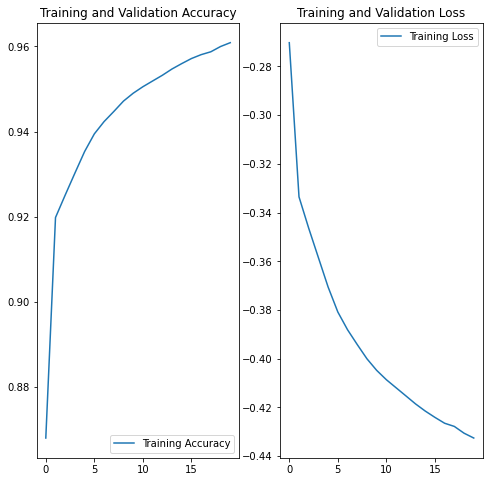

In [22]:
#history = model_history
accuracy = history.history['binary_accuracy']
#val_acc = history.history['val_dice_coef']

loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#print(history.history['accuracy'])

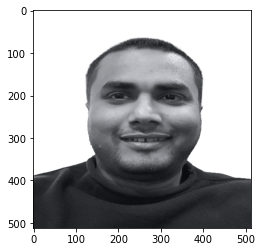

In [24]:
#img_path = f"{PATH}/test/IMG_1852.png"
#img_path = f"{PATH}/test/test1.png"
img_path = f"{PATH}/test/profile3.png"
#img_path = f"{PATH}/test/sahas-standing.png"
#img_path = f"{PATH}/test/sahas.png"

test_img = None
test_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(WIDTH, HEIGHT))
plt.imshow(test_img)

In [25]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [26]:
print(type(test_img))
test_img = tf.keras.preprocessing.image.img_to_array(test_img)
print(test_img.shape)
test_img = tf.expand_dims(test_img, 0)
print(test_img.shape)
test_pred = model.predict(test_img)
test_mask = create_mask(test_pred)

<class 'PIL.Image.Image'>
(512, 512, 3)
(1, 512, 512, 3)


(1, 512, 512, 1)
(512, 512, 1)


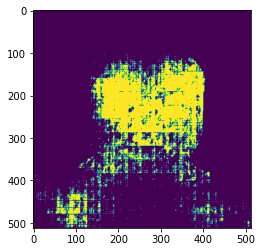

In [27]:
print(test_mask.shape)
test_mask = tf.squeeze(test_mask, axis=0)
print(test_mask.shape)
mask_img = tf.keras.preprocessing.image.array_to_img(test_mask)
#print(mask_img)
plt.imshow(mask_img)